In [47]:

df["Age"].fillna(df["Age"].median(), inplace=True)
df["Fare"].fillna(df["Fare"].median(), inplace=True)


df.drop(columns=["Cabin", "PassengerId", "Name", "Ticket"], inplace=True)

df.isnull().sum()


/tmp/ipython-input-2970681102.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
/tmp/ipython-input-2970681102.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])
df["Embarked"] = le.fit_transform(df["Embarked"])


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)


print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Baseline Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [50]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_acc = accuracy_score(y_test, log_reg.predict(X_test))


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf.predict(X_test))


xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
xgb_acc = accuracy_score(y_test, xgb.predict(X_test))

print("Logistic Regression Accuracy:", log_acc)
print("Random Forest Accuracy:", rf_acc)
print("XGBoost Accuracy:", xgb_acc)


Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 1.0
XGBoost Accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 1.0


In [52]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df.drop(columns=['SibSp', 'Parch'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,0,3,1,34.5,7.8292,1,1,1
1,1,3,0,47.0,7.0000,2,2,0
2,0,2,1,62.0,9.6875,1,1,1
3,0,3,1,27.0,8.6625,2,1,1
4,1,3,0,22.0,12.2875,2,3,0


In [53]:
from sklearn.preprocessing import StandardScaler

categorical_cols = ['Sex', 'Embarked', 'Pclass']
numerical_cols = ['Age', 'Fare', 'FamilySize']

df_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)

scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df[numerical_cols])
df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=numerical_cols, index=df.index)

df_processed = pd.concat([df_numerical_scaled, df_categorical, df[['Survived', 'IsAlone']]], axis=1)
df_processed.head()

,Age,Fare,FamilySize,Sex,Embarked,Pclass,Survived,IsAlone
0,0.386231,-0.497413,-0.553443,1,1,3,0,1
1,1.371370,-0.512278,0.105643,0,2,3,1,0
2,2.553537,-0.464100,-0.553443,1,1,2,0,1
3,-0.204852,-0.482475,-0.553443,1,2,3,0,1
4,-0.598908,-0.417492,0.764728,0,2,3,1,0


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_processed.drop("Survived", axis=1)
y = df_processed["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log_reg)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print("Logistic Regression Accuracy:", log_acc)
print("Random Forest Accuracy:", rf_acc)
print("XGBoost Accuracy:", xgb_acc)

Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 1.0
XGBoost Accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:01:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Random Forest Best Params:", grid_rf.best_params_)
print("Random Forest Best Accuracy:", grid_rf.best_score_)

Random Forest Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Accuracy: 1.0


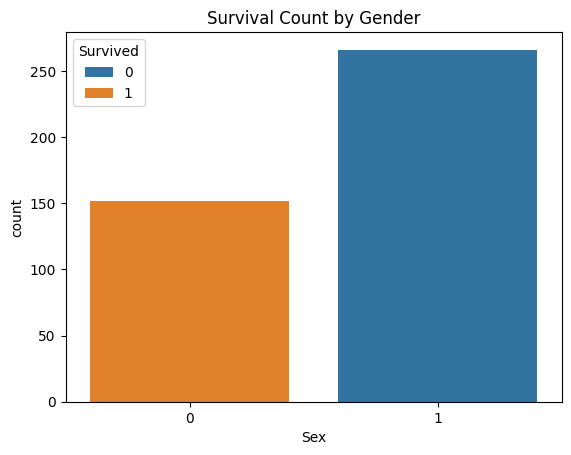

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Survival Count by Gender")
plt.show()


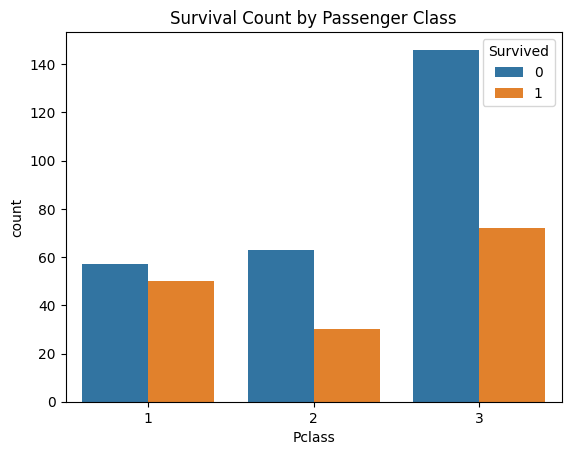

In [57]:
sns.countplot(x="Pclass", hue="Survived", data=df)
plt.title("Survival Count by Passenger Class")
plt.show()


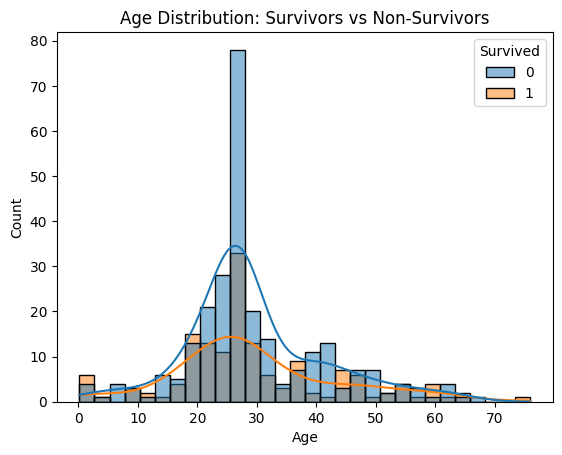

In [58]:
sns.histplot(data=df, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Age Distribution: Survivors vs Non-Survivors")
plt.show()
